In [20]:
import pandas as pd
from scipy import stats

from funciones.parametros import *
from funciones.outliers_tukey import *

### OUTLIERS I & II:

**ACLARACIÓN: este notebook es para mostrar cómo funcionan las funciones de limpieza de outliers, así que usamos uno de los datasets sin sobreescribir el original**

Los datos de DEMANDA nos ofrecen datos de los territorios:

- nacional 
- peninsular 
- canarias
- ceuta
- melilla

Para valorar qué enfoque usar con los outliers, usamos **stats** de scipy con significancia 0.05 para valorar si las distribuciones son normales o no.

Tras ver que hay más distribuciones no normales, decidimos usar Valla de Tukey. Creamos varias funciones: 

- visualiza_outliers_tukey(): muestra histograma de los valores de demanda, representando los outliers (k=1.5) en rojo, el resto en azul.

- aisla_outliers_tukey(): aisla los outliers por año y territorio y devuelve un dataframe sólo con ellos. De esta manera, podemos analizar cuando se producen esos valores atípicos (por ejemplo, en un verano excepcionalmente caluroso).

- sustituye_outliers_tukey(): tras visualizar y aislar los outliers, los sutituímos por los valores límite con Valla de Tukey. Esta función actúa directamente sobre la columna **valor_(MWh)** para sobreescribir el dataframe de demanda original.

El año 2010 no devuelve valores atípicos, así que capturamos el IndexError con un try-except.

In [22]:
df_demanda_historico = pd.read_csv("../data/processed/OUTLIERS_DF_DEMANDA_10_25_LIMPIO.csv")

In [23]:
años = [int(año) for año in df_demanda_historico["año"].unique()]

territorios = [territorio for territorio in df_demanda_historico["zona"].unique()]

In [24]:
# Valoracion distribuciones

# Significancia
alpha = 0.05

total_normales = 0
total_no_normales = 0

for año in años:
    
    normales = 0
    no_normales = 0

    for territorio in territorios:
        
        df = df_demanda_historico[(df_demanda_historico["año"] == año) \
                                & (df_demanda_historico["zona"] == territorio)\
                                &(df_demanda_historico["categoria"] == "Evolución de la demanda")]

        _, p_muestra_1 = stats.normaltest(df["valor_(MWh)"])

        if p_muestra_1 < alpha:
            no_normales += 1
            student = False

        else:
            normales += 1

    total_normales+= normales
    total_no_normales+= no_normales

print(f"Total distribuciones normales: {total_normales}")
print(f"Total distribuciones no normales: {total_no_normales}")

# /tmp/ipykernel_5886/4074404330.py:20: SmallSampleWarning: ESTO SE DEBE A QUE EN 2010 NO DETECTA OUTLIERS

/tmp/ipykernel_6034/1389986609.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_muestra_1 = stats.normaltest(df["valor_(MWh)"])


Total distribuciones normales: 32
Total distribuciones no normales: 64


---

### OUTLIERS I: 

#### Aplicamos visualiza_outliers_tukey() con año 2024

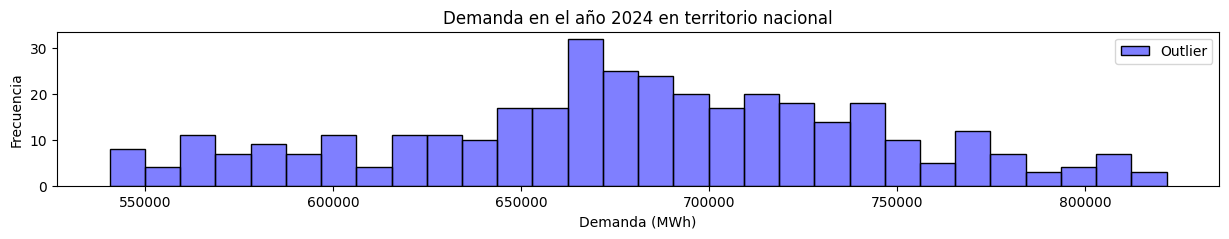

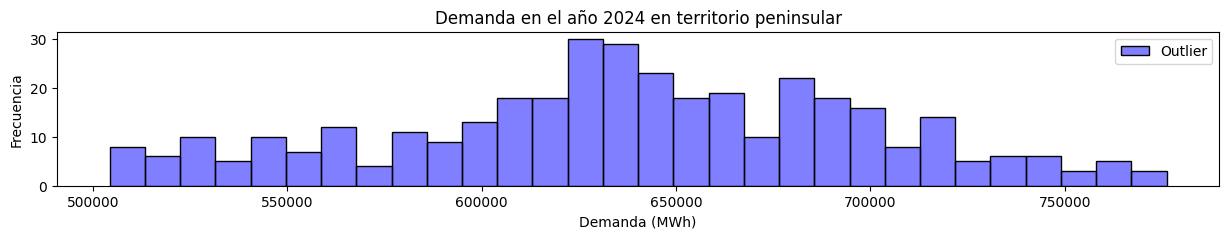

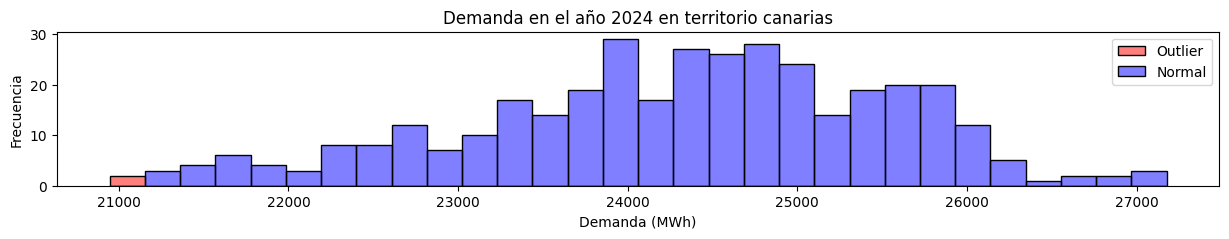

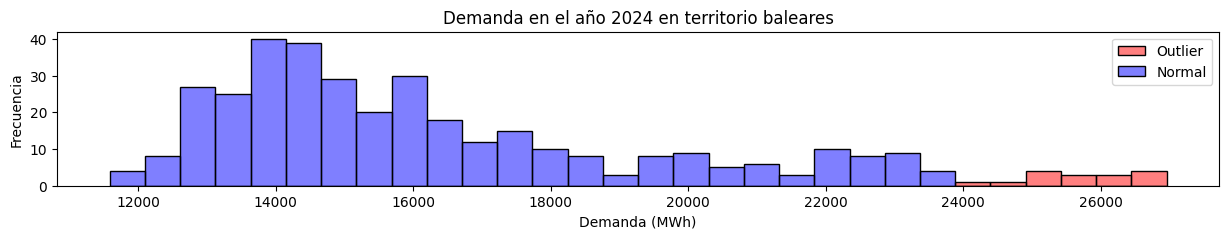

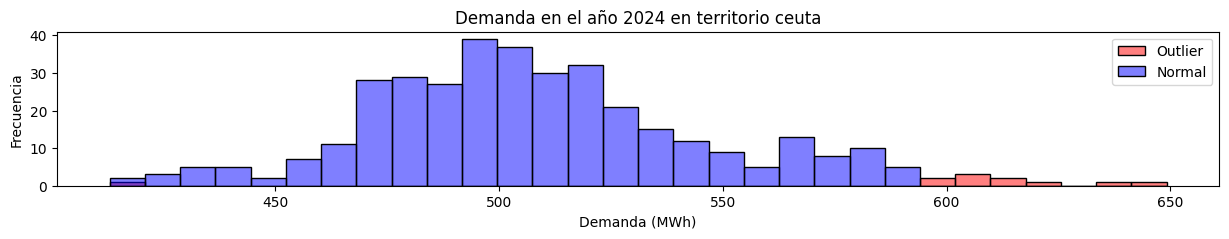

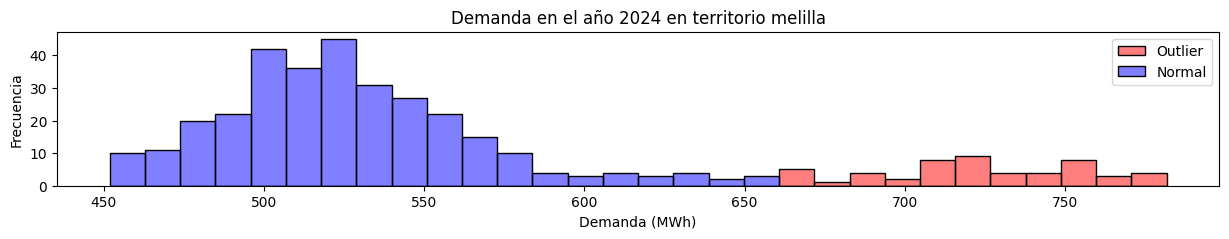

In [25]:
for territorio in territorios:
    df = df_demanda_historico[(df_demanda_historico["año"] == 2024) \
                                    & (df_demanda_historico["zona"] == territorio)\
                                    &(df_demanda_historico["categoria"] == "Evolución de la demanda")]
    try:
        visualiza_outliers_tukey(df, 2024, territorio)
    except IndexError:
        print(f"No hay datos a visualizar del territorio {territorio} en el año {2024}")

---

### OUTLIERS II: 

#### Aplicamos visualiza_outliers_tukey() a todos los años y territorios:

No hay datos a visualizar del territorio nacional en el año 2010
No hay datos a visualizar del territorio peninsular en el año 2010
No hay datos a visualizar del territorio canarias en el año 2010
No hay datos a visualizar del territorio baleares en el año 2010
No hay datos a visualizar del territorio ceuta en el año 2010
No hay datos a visualizar del territorio melilla en el año 2010


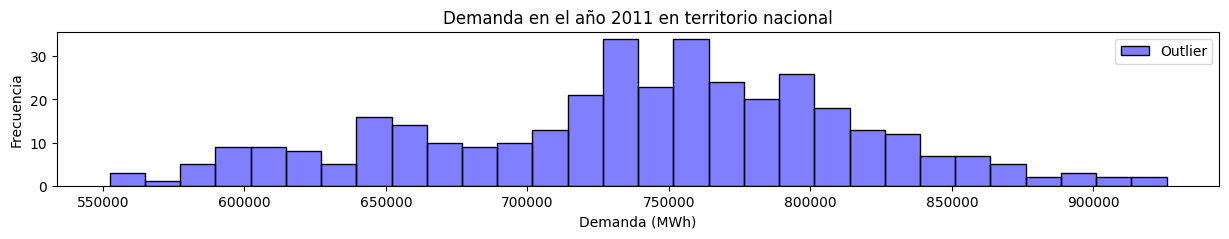

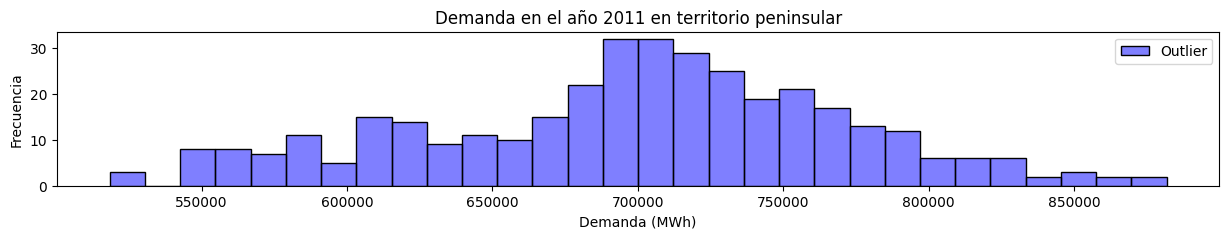

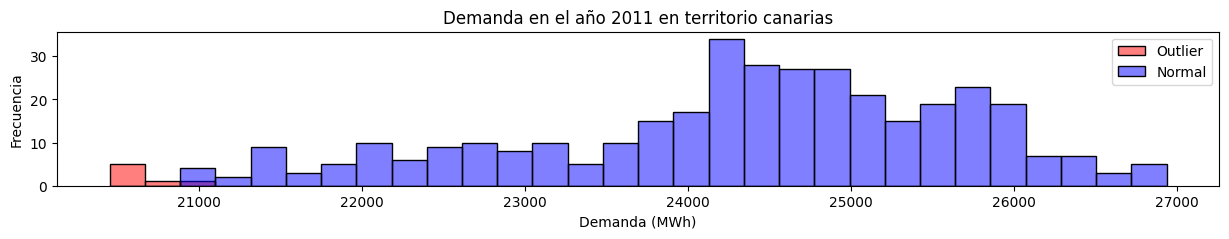

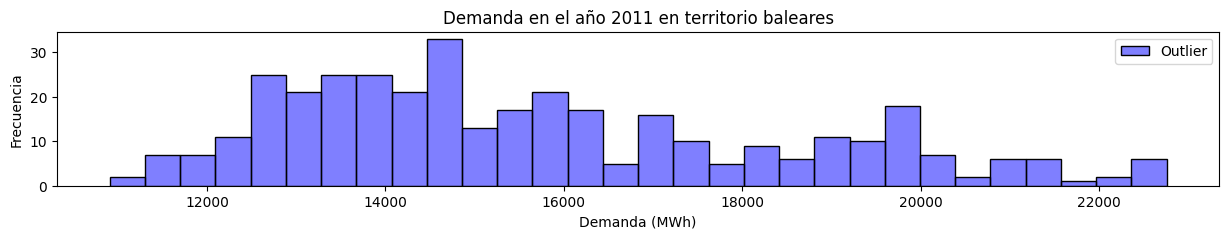

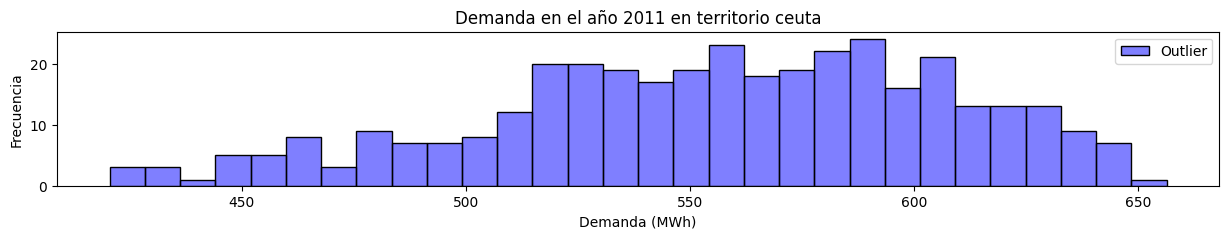

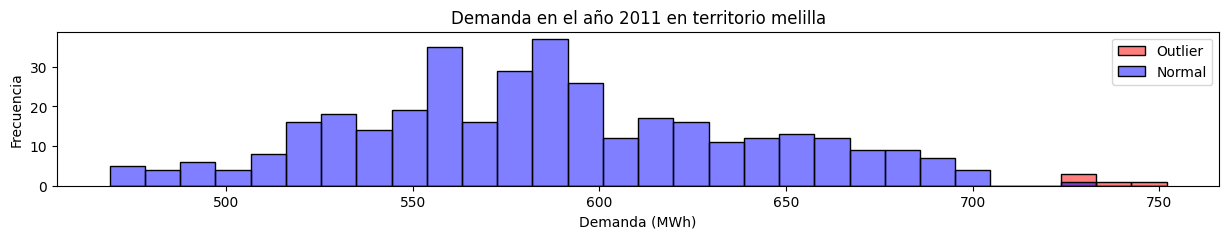

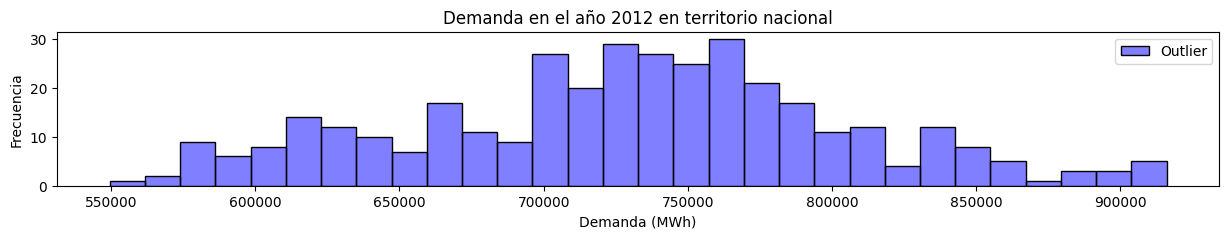

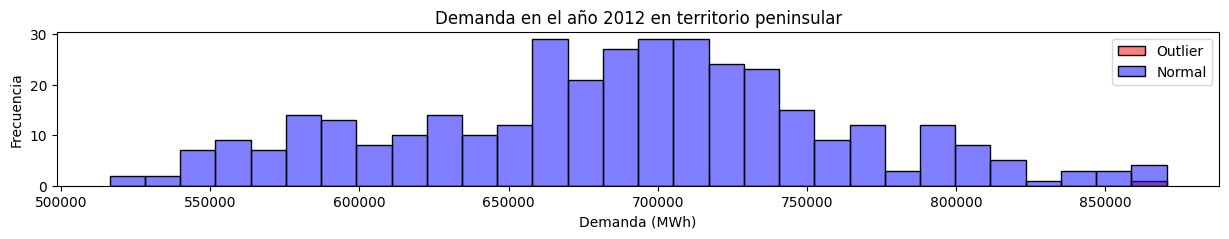

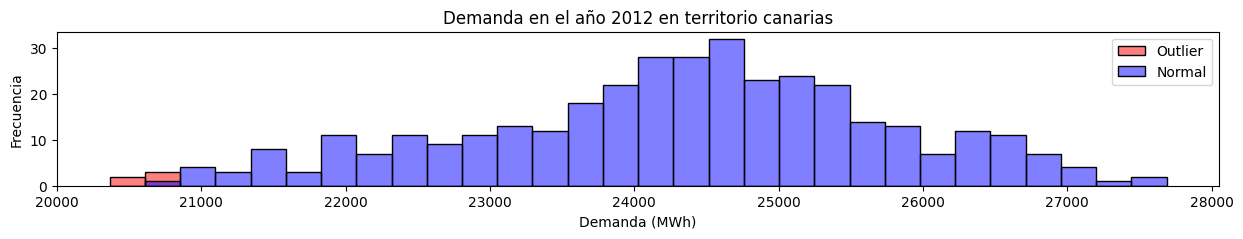

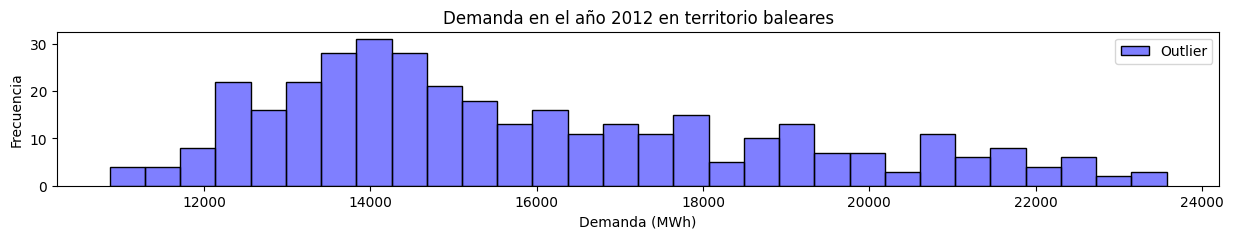

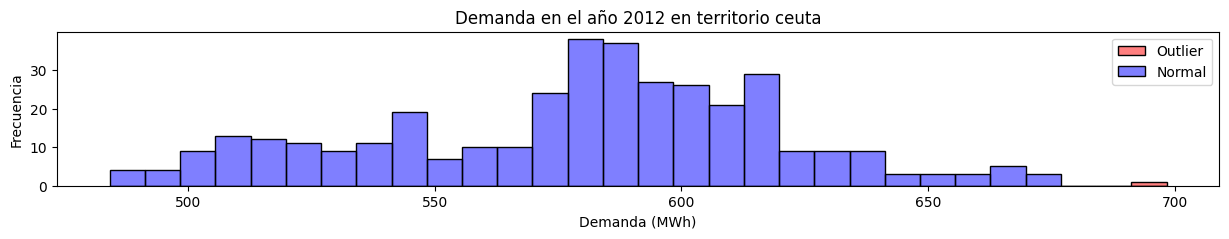

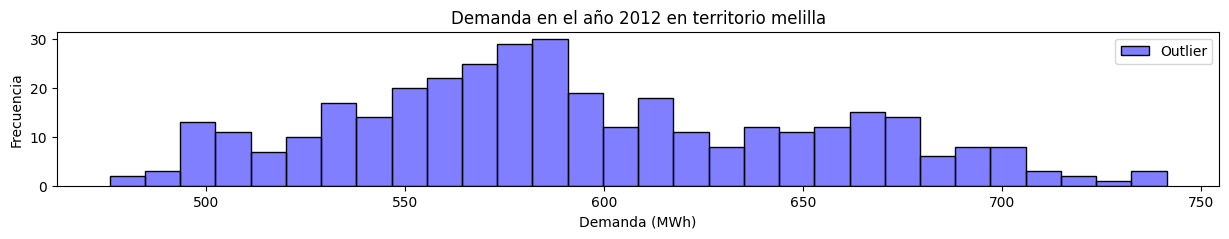

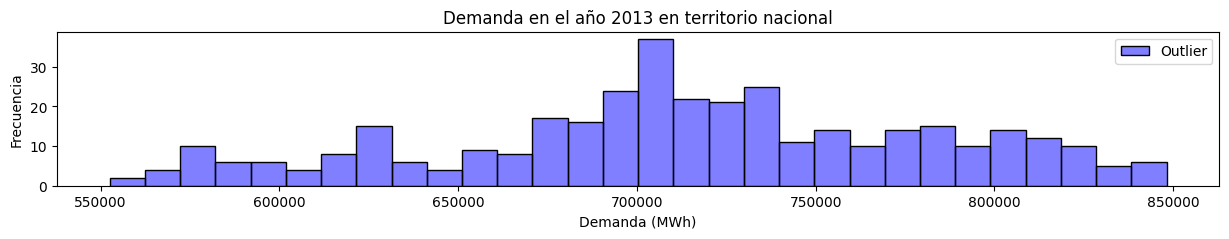

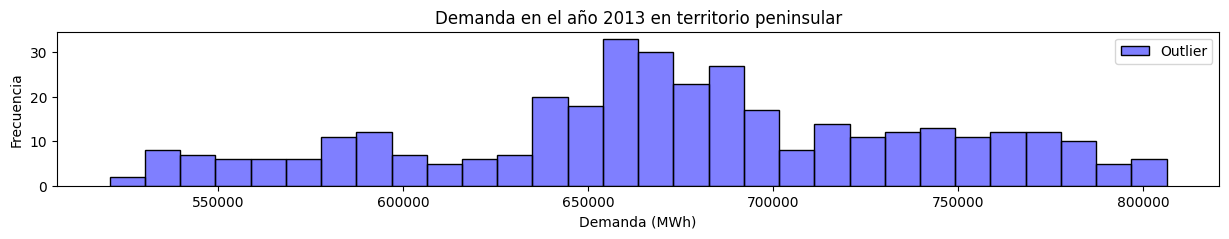

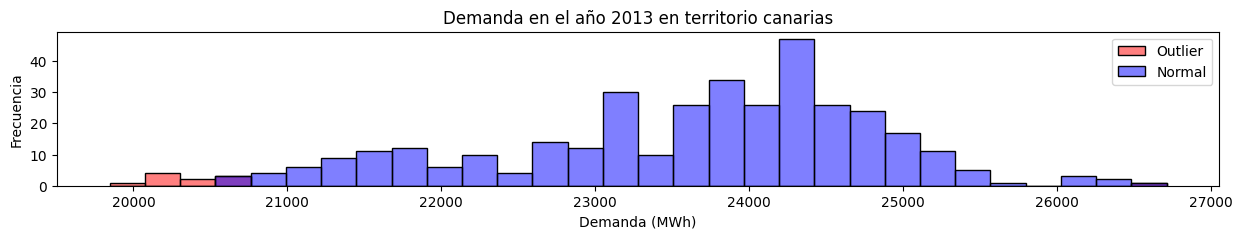

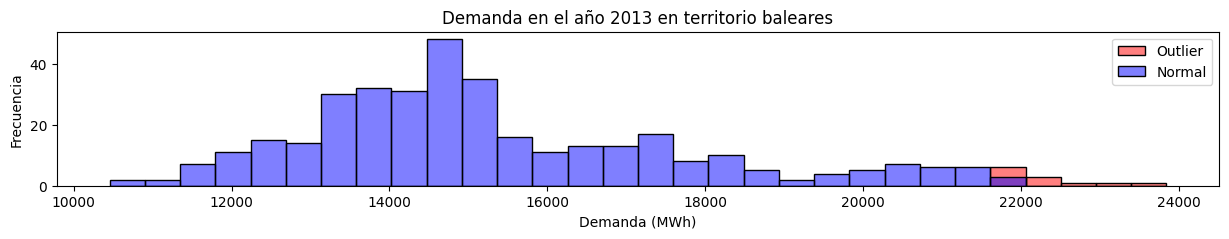

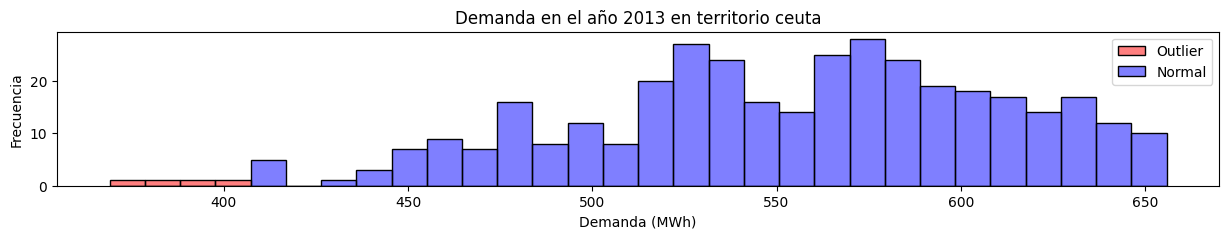

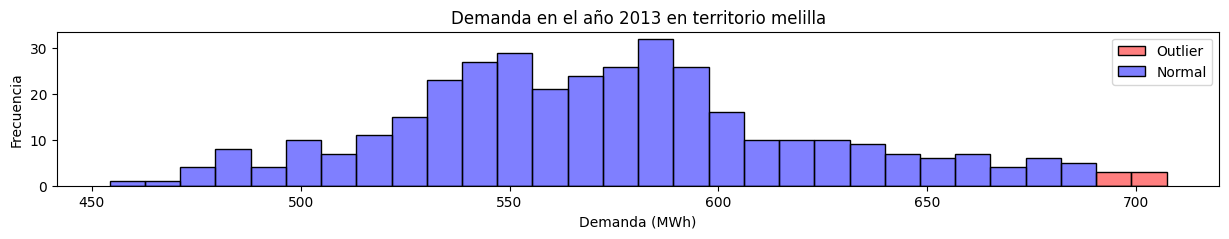

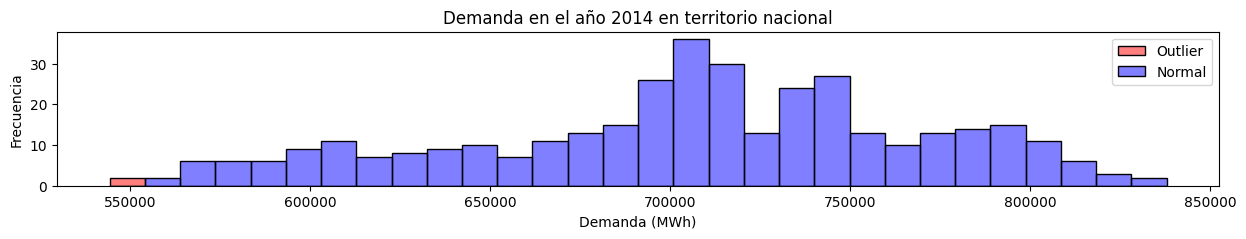

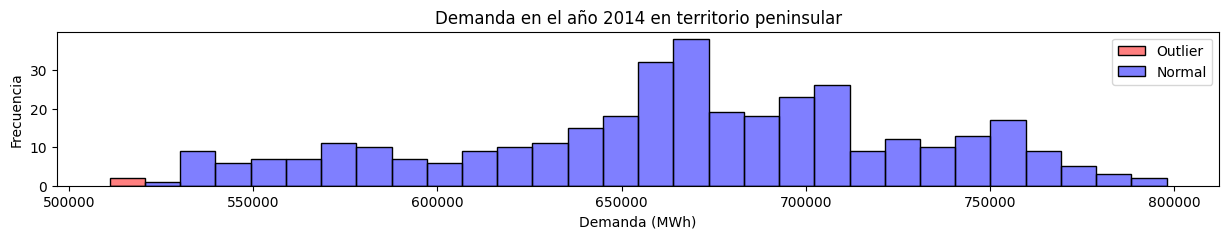

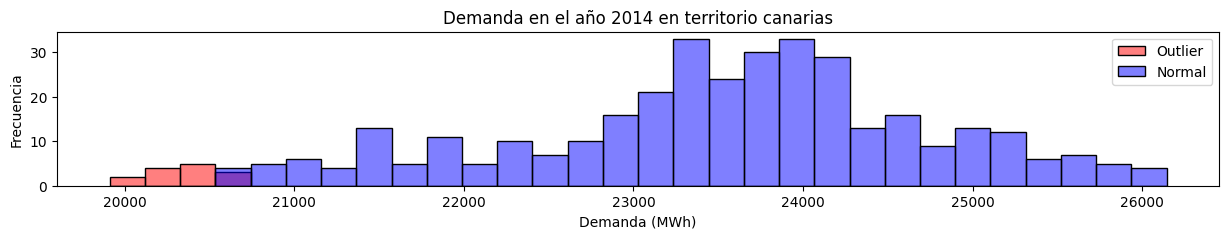

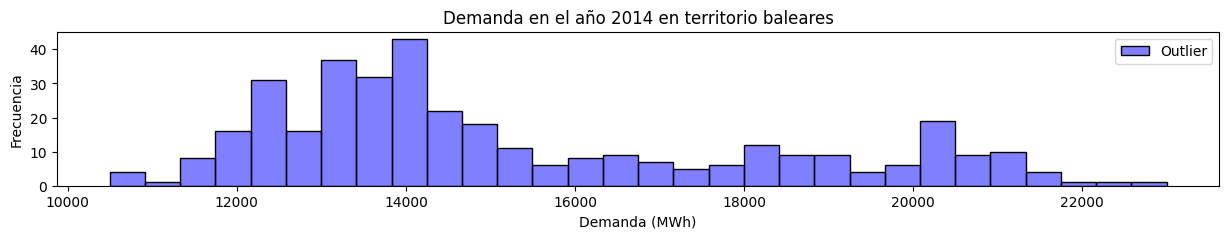

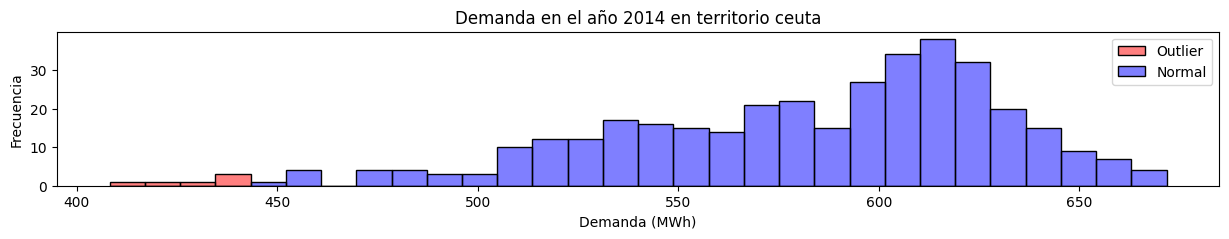

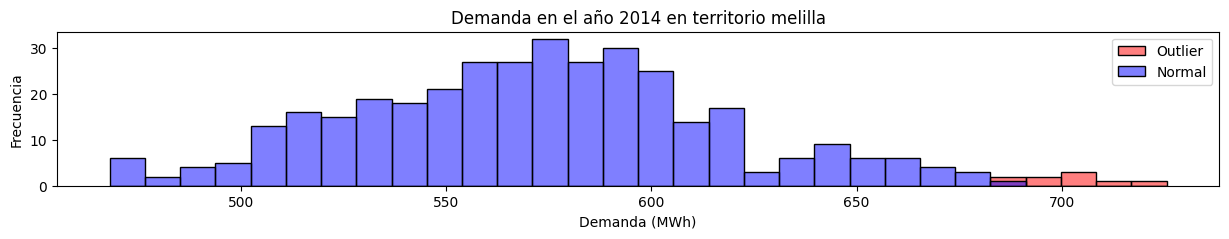

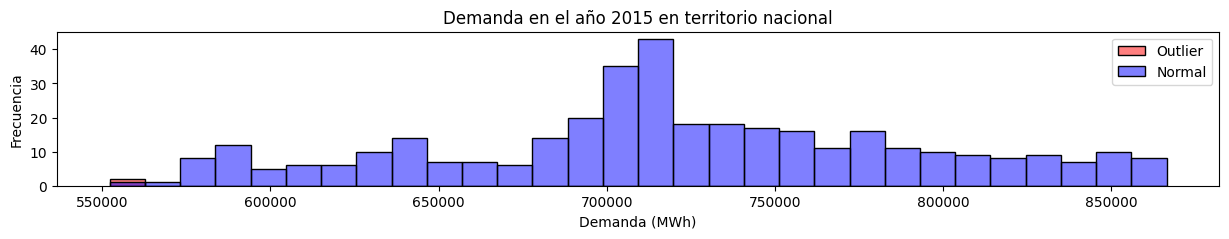

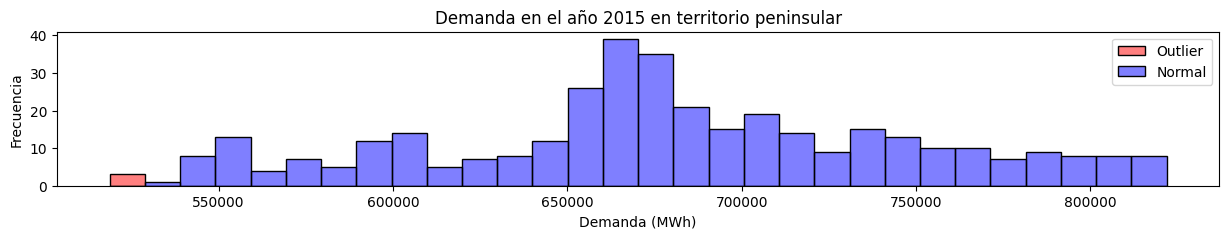

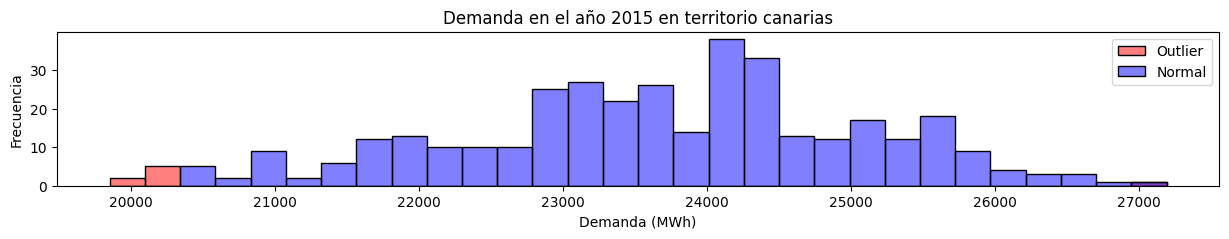

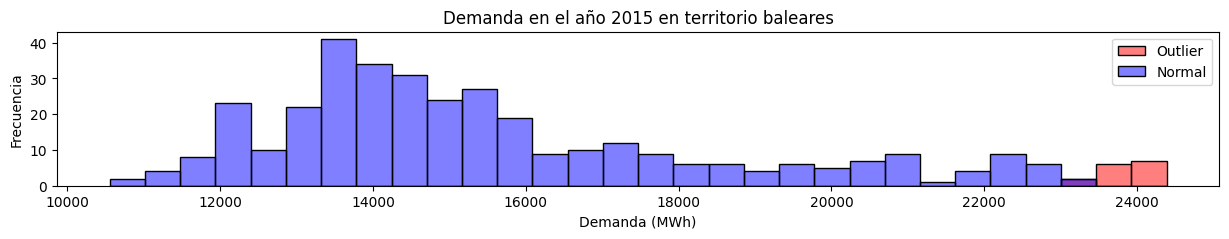

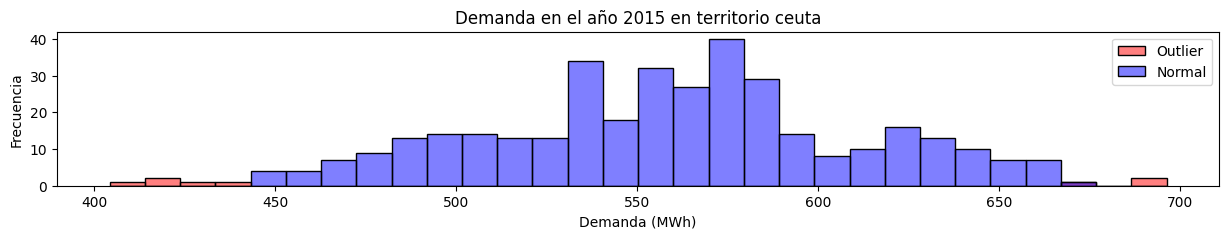

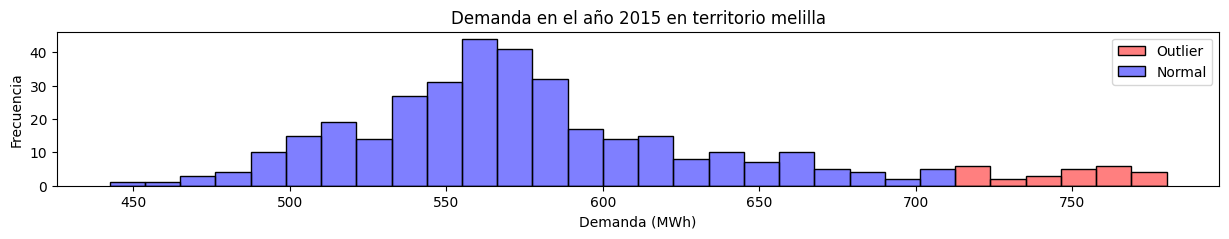

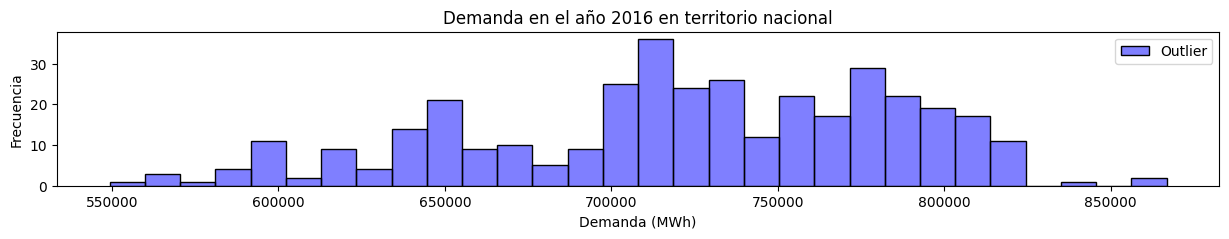

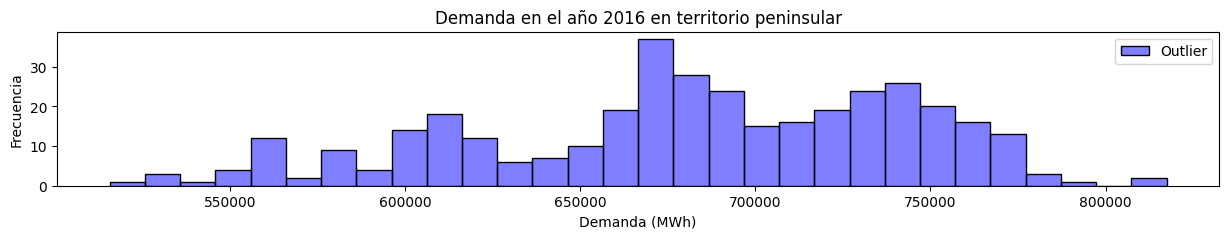

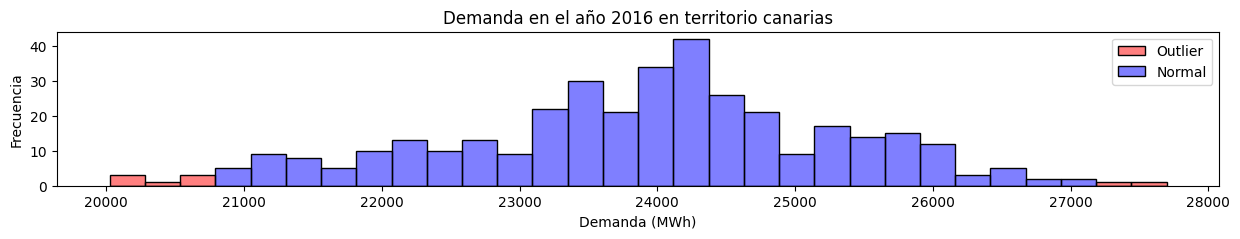

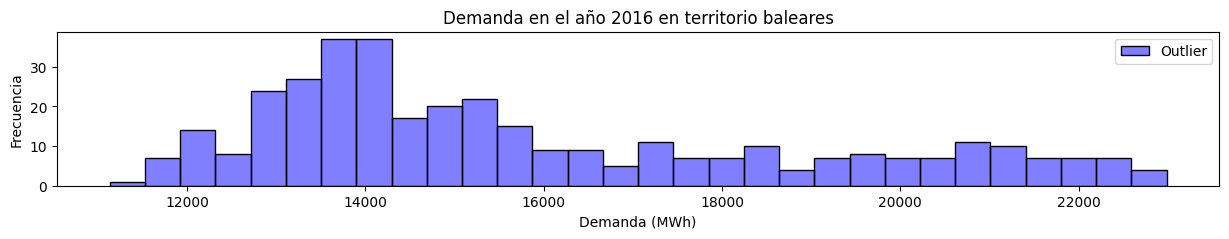

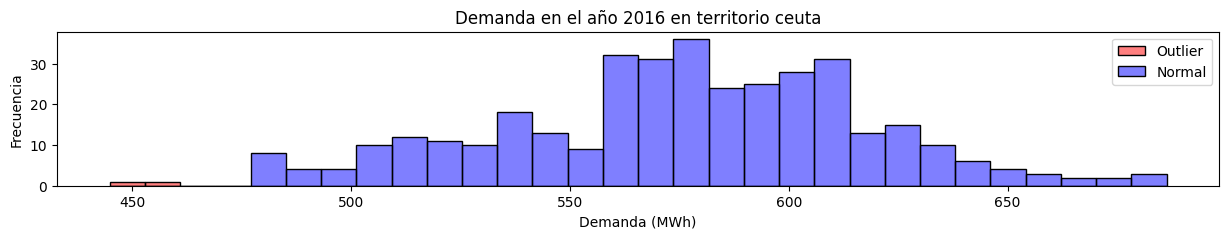

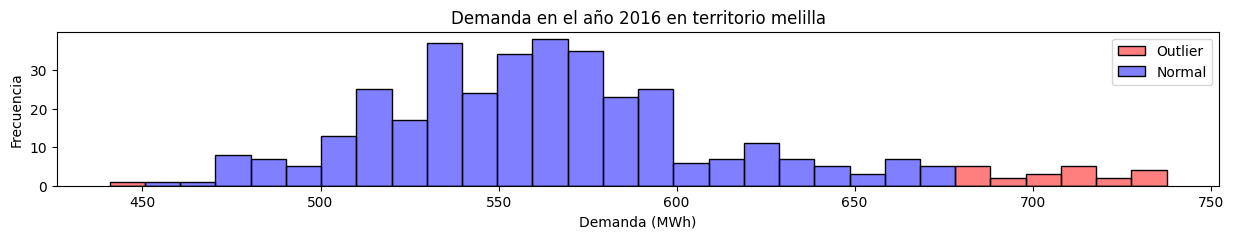

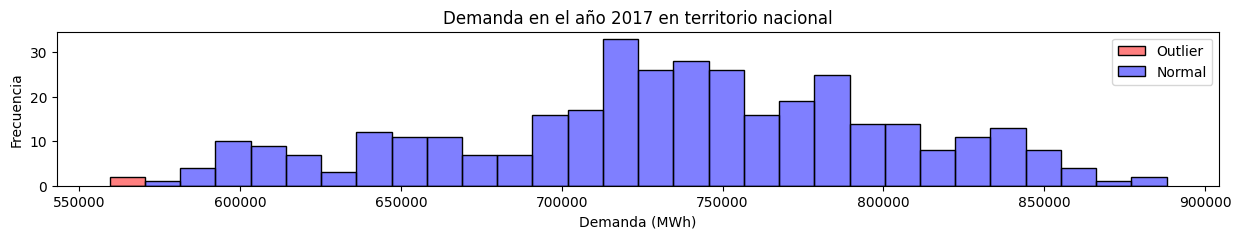

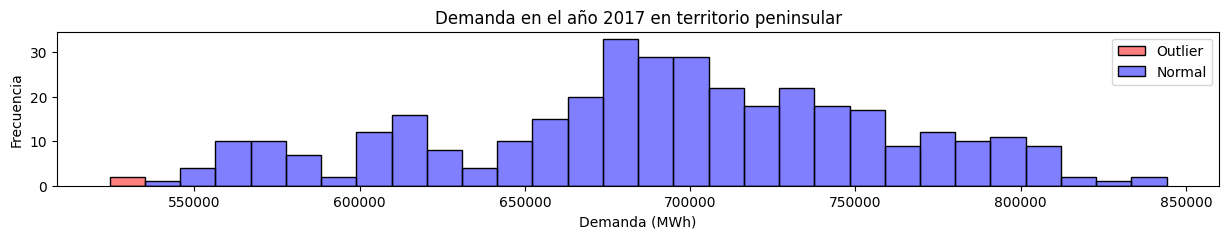

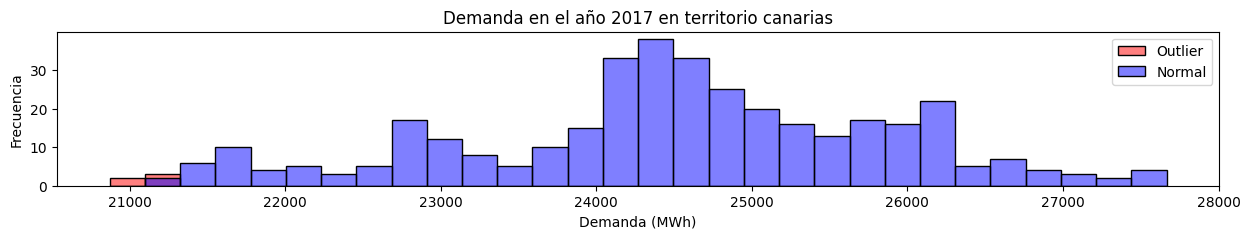

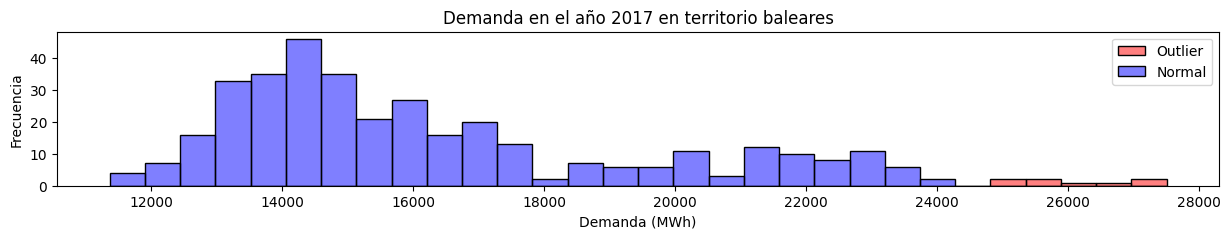

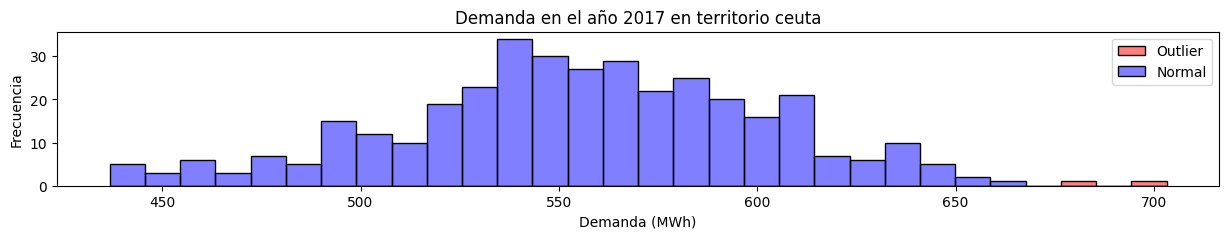

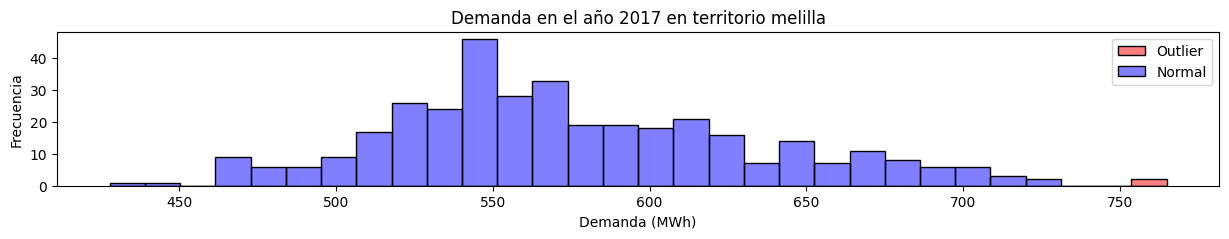

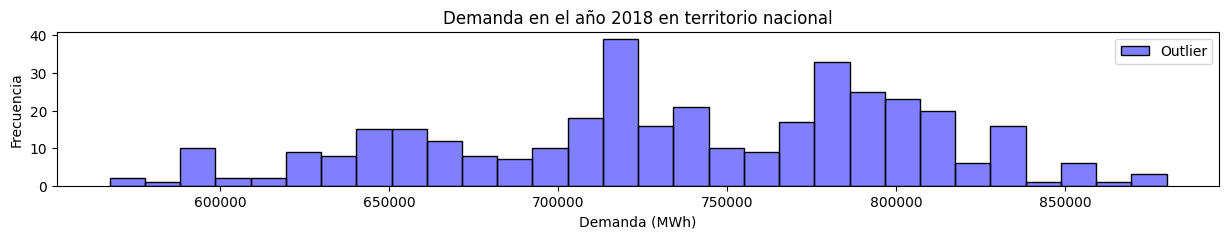

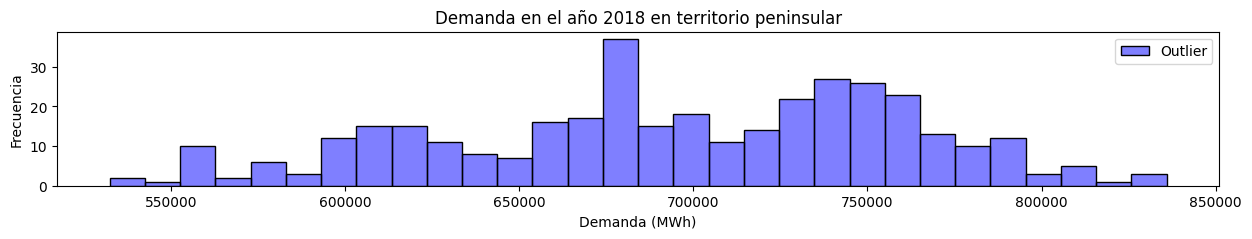

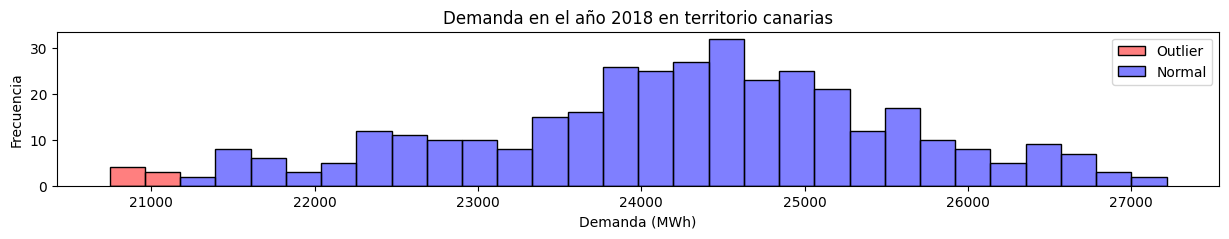

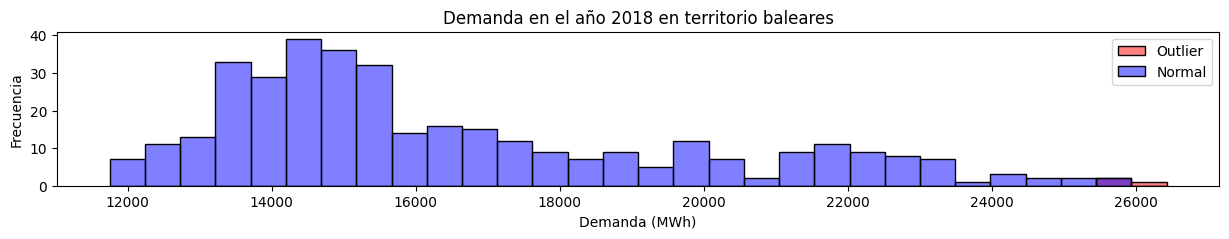

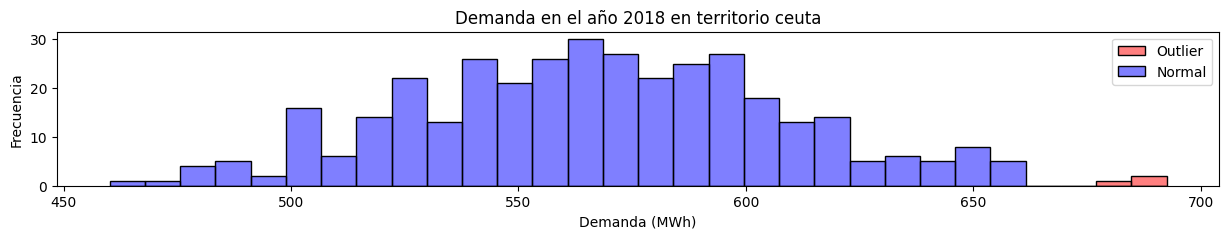

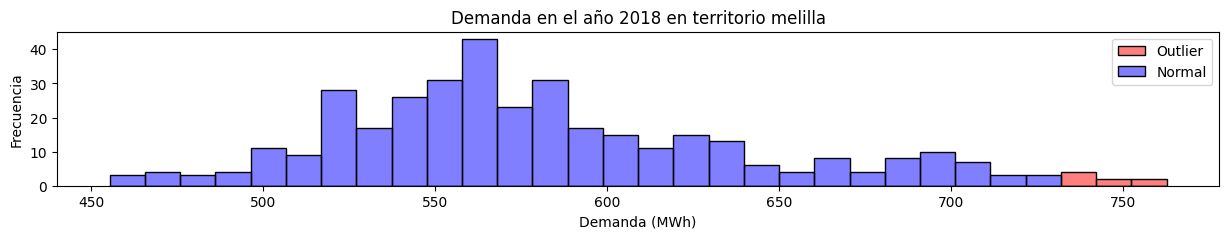

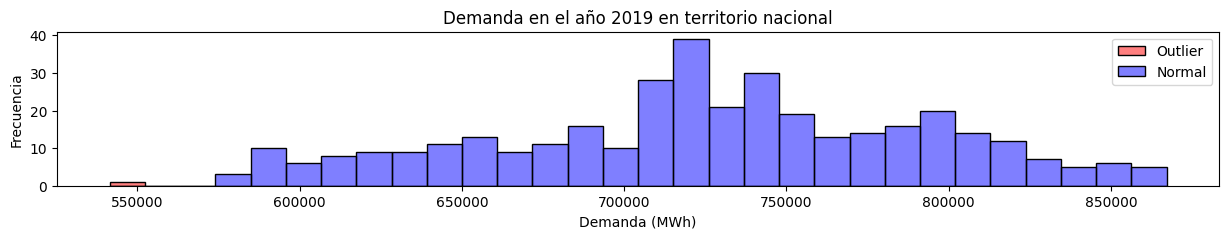

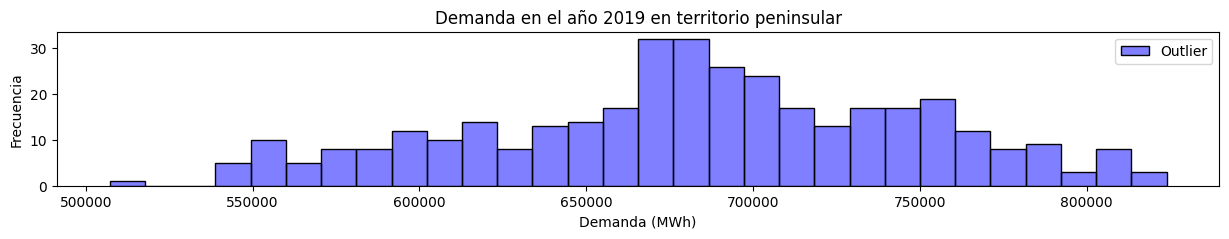

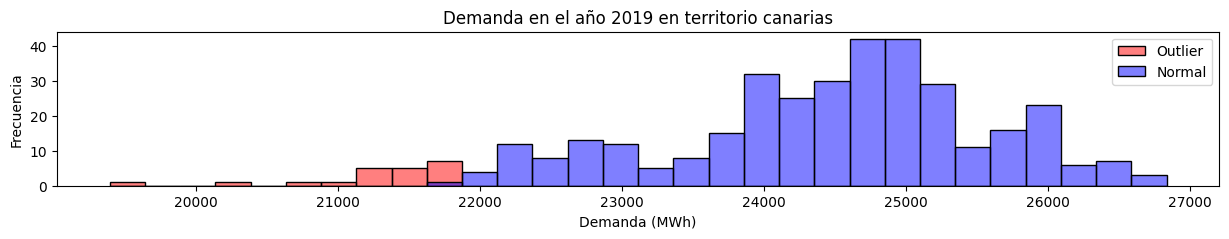

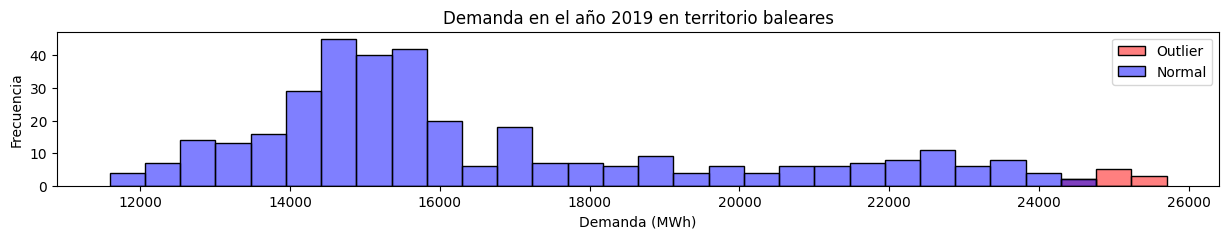

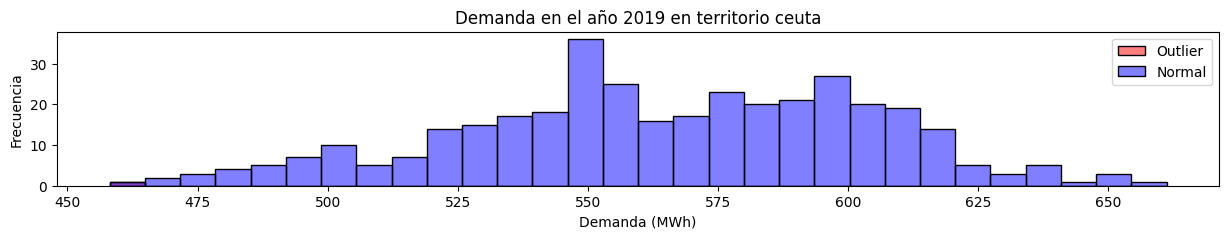

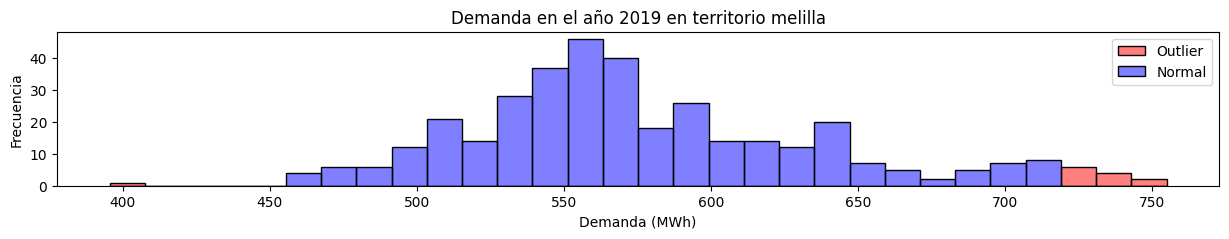

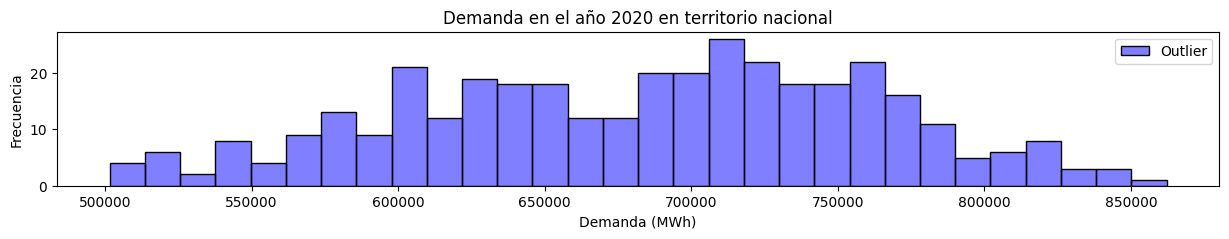

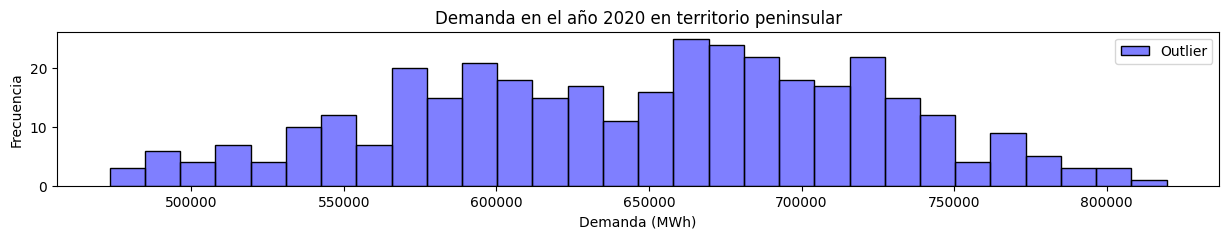

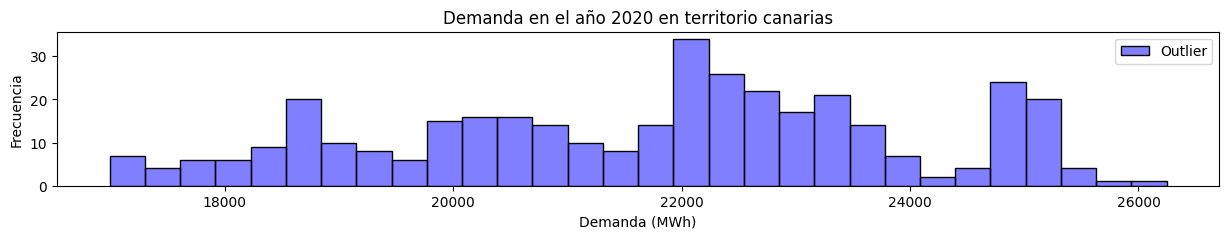

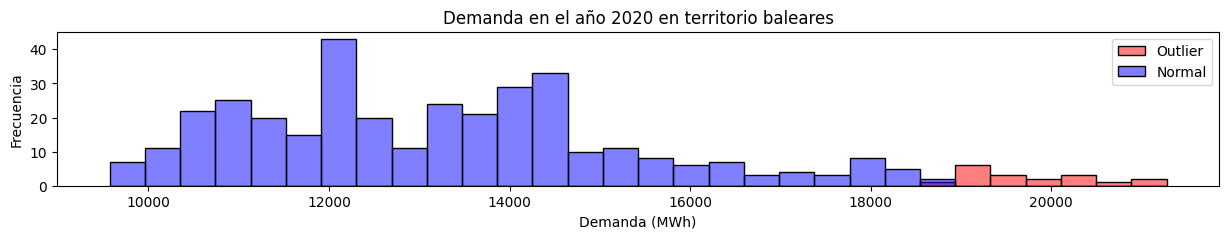

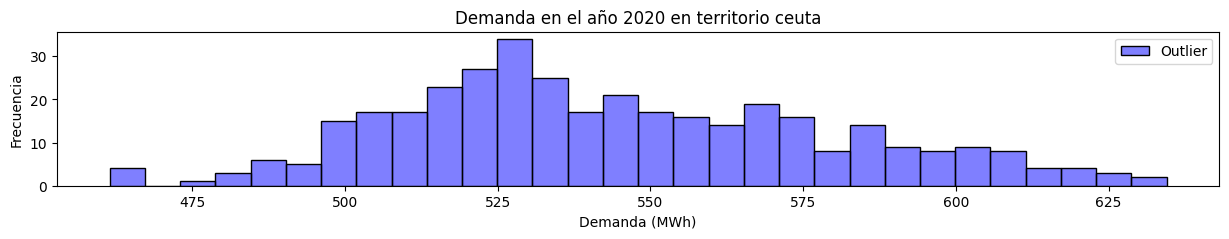

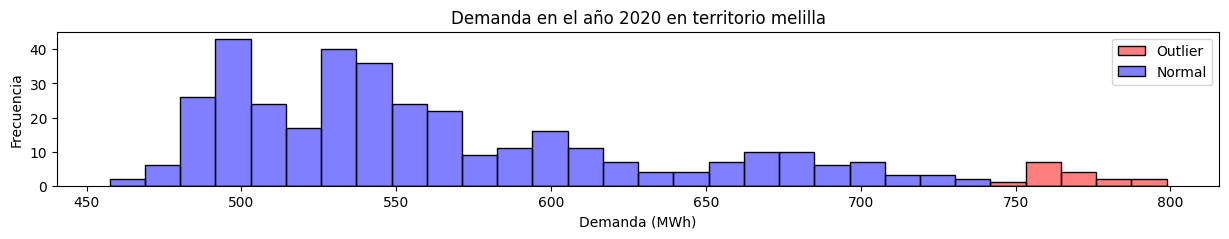

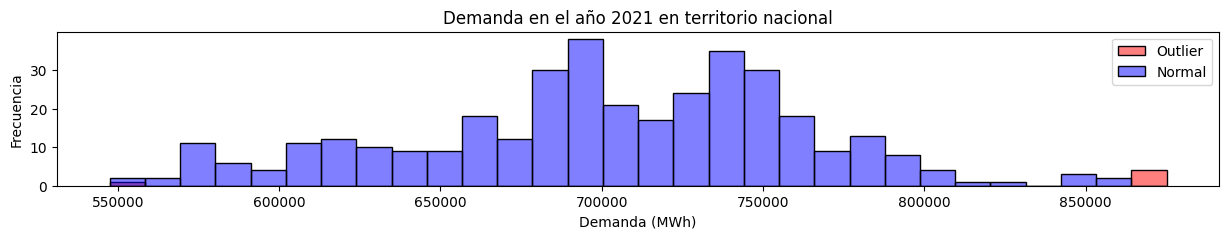

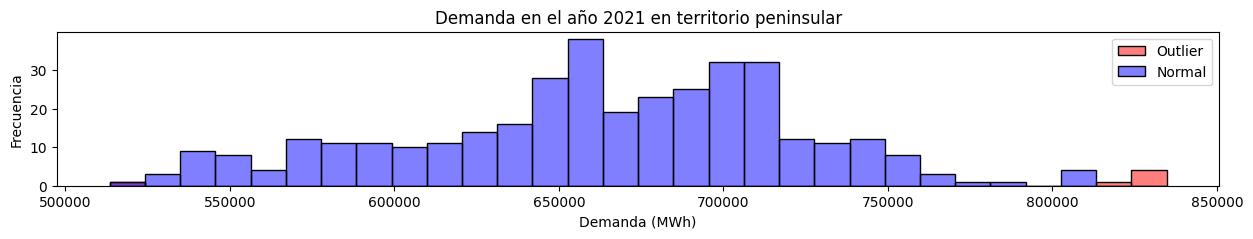

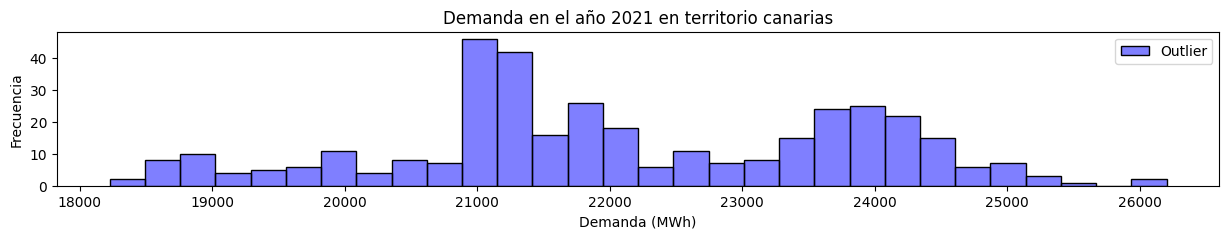

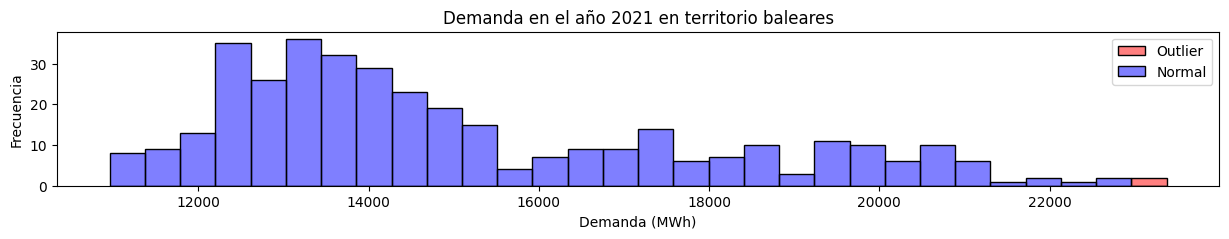

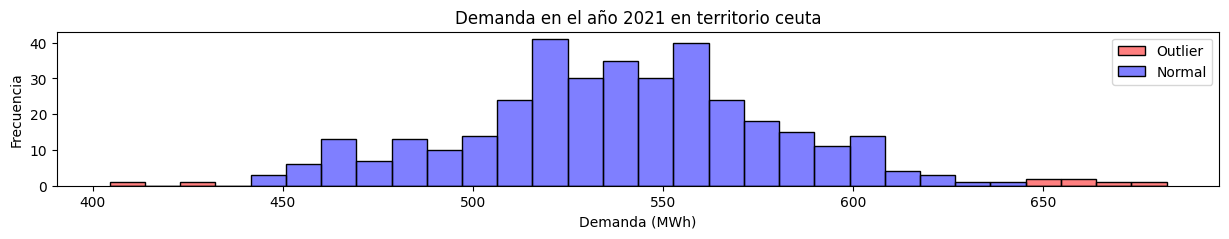

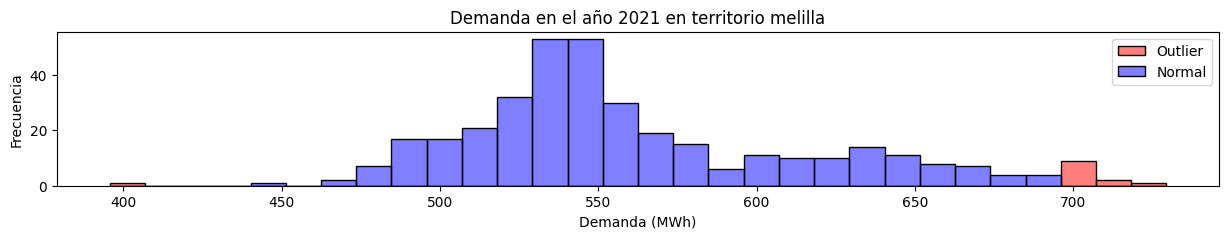

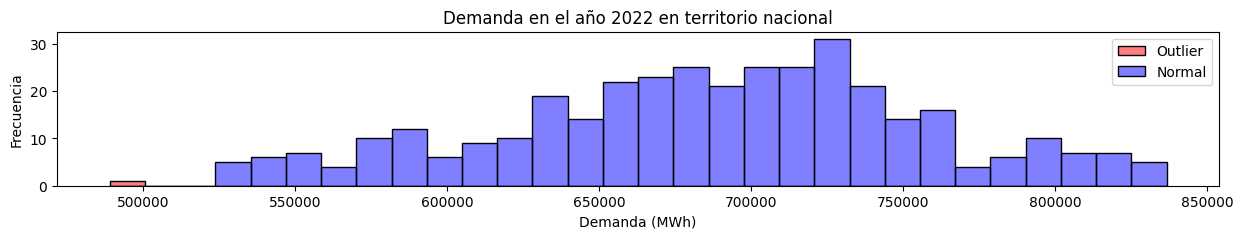

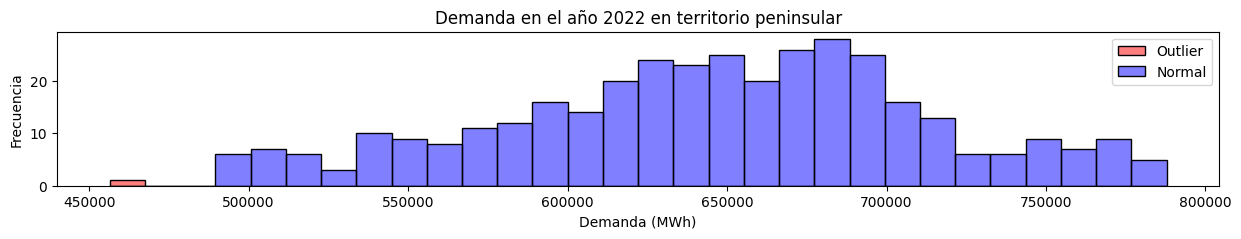

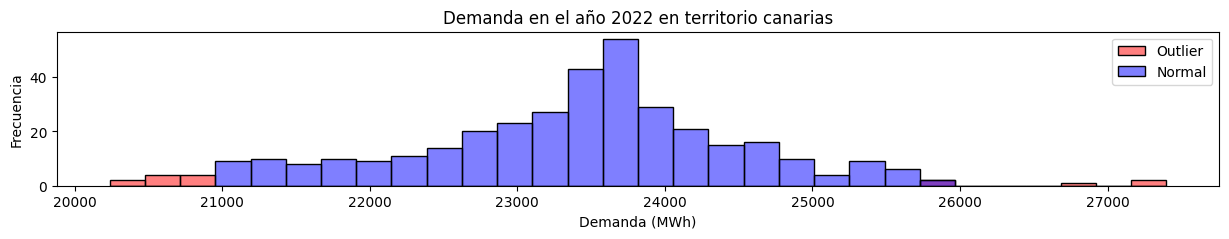

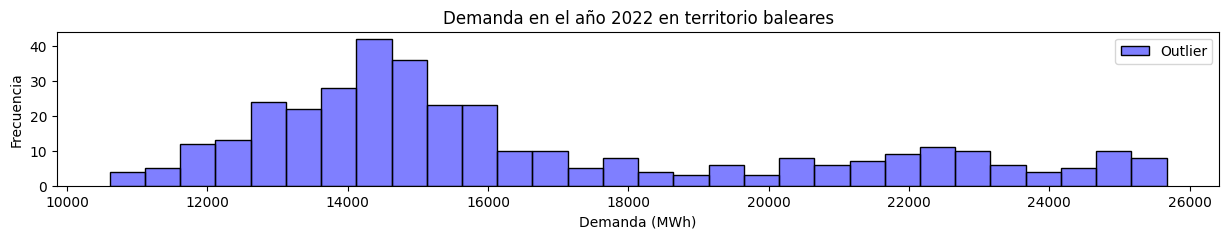

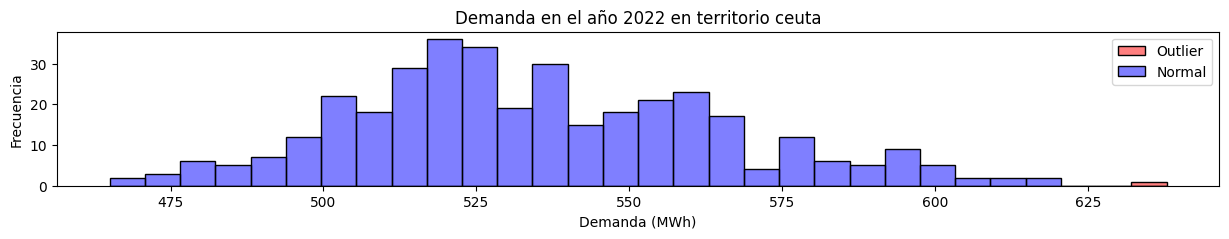

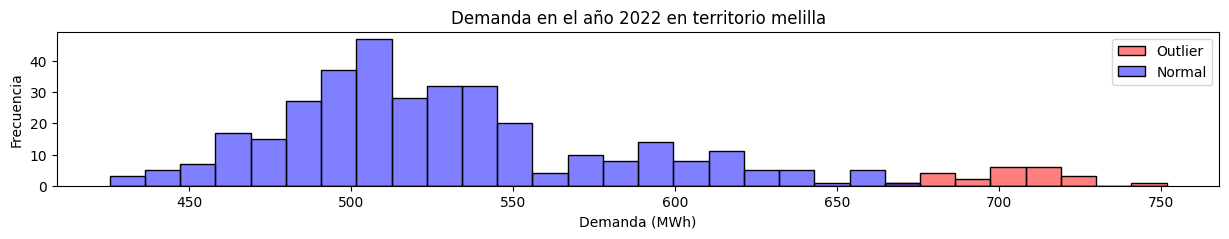

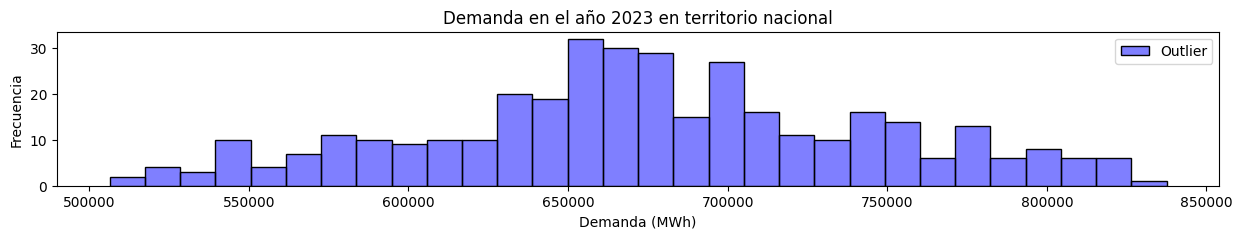

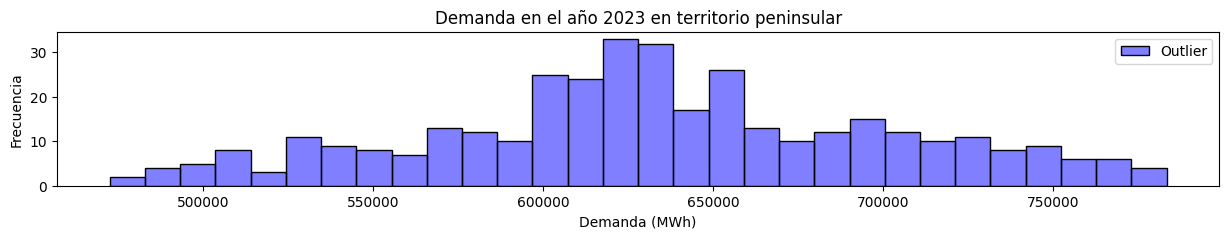

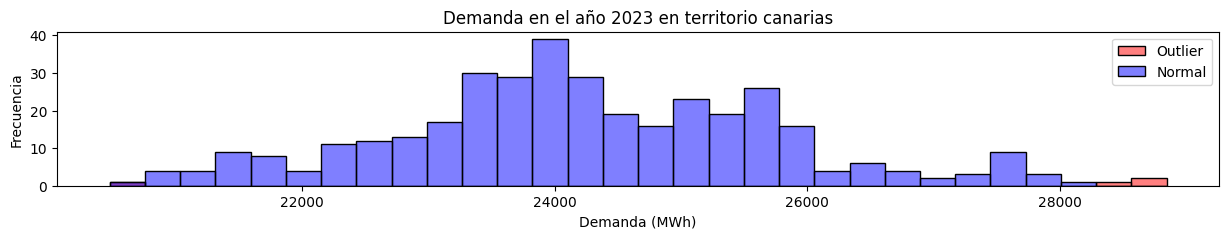

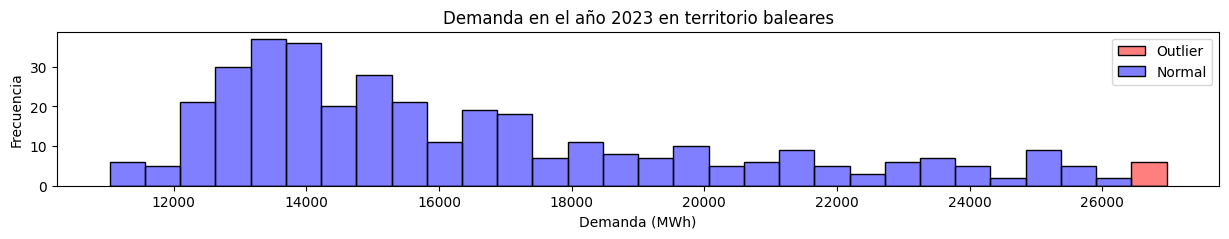

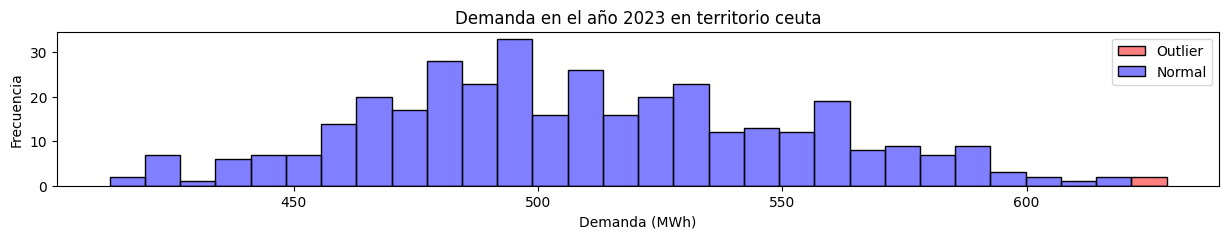

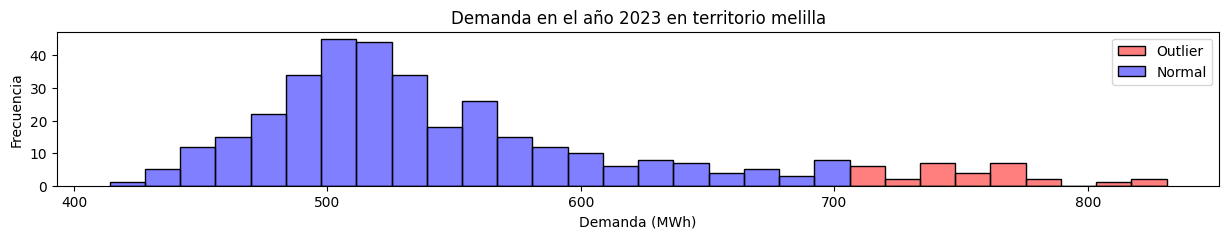

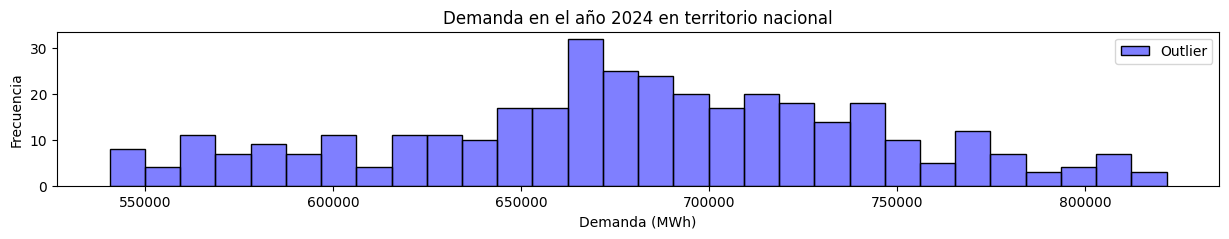

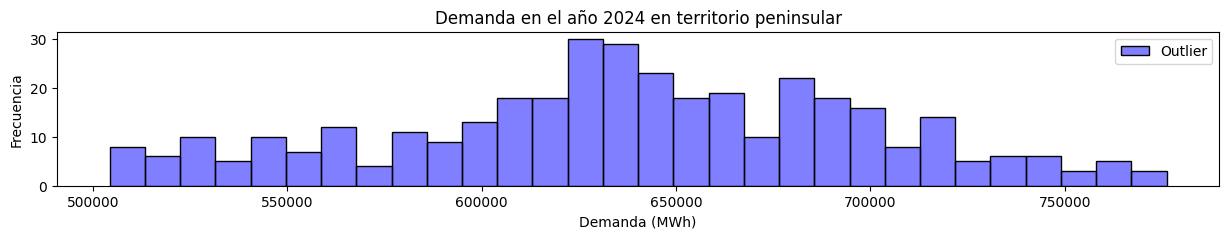

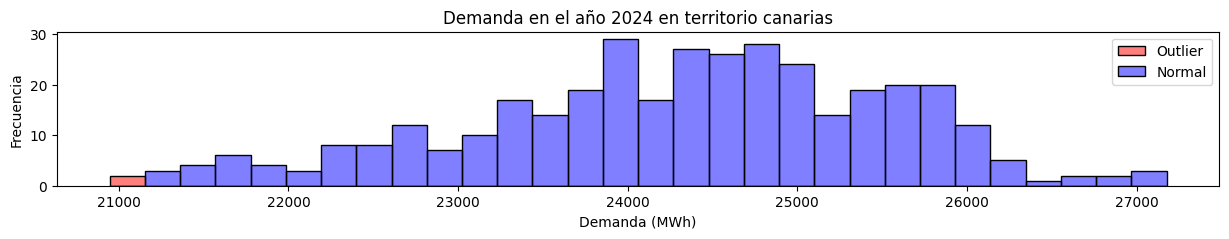

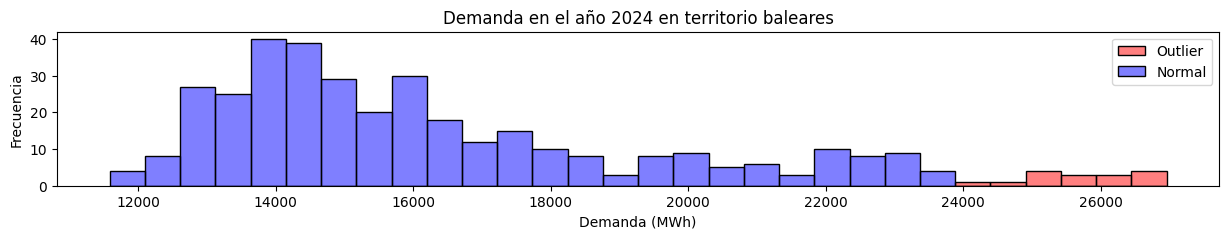

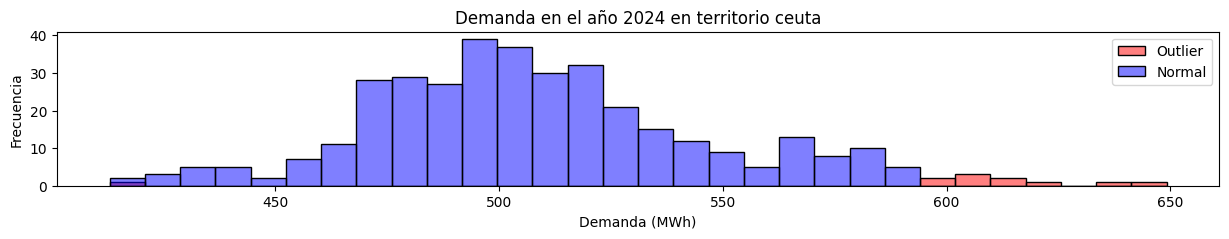

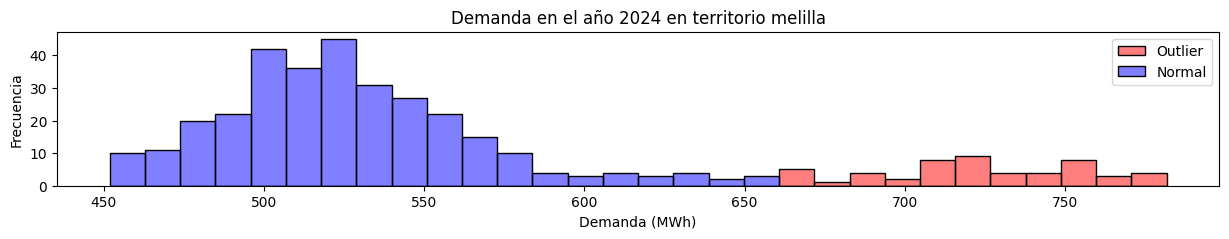

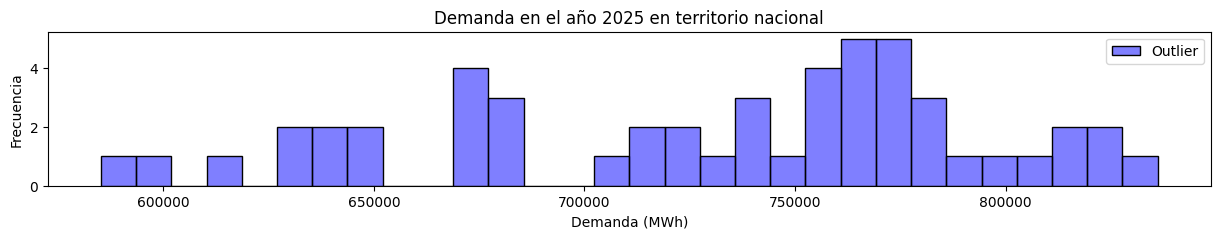

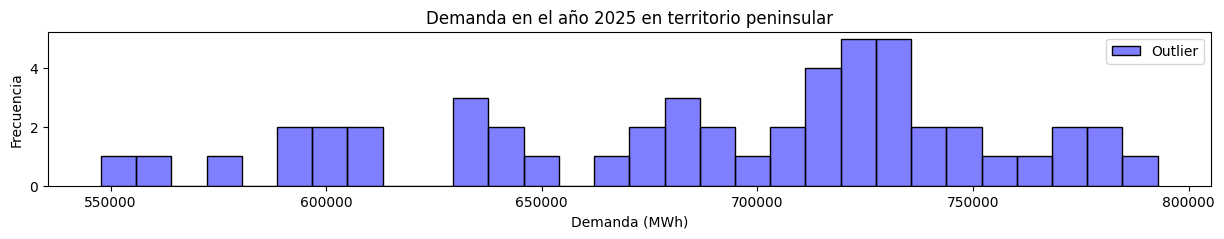

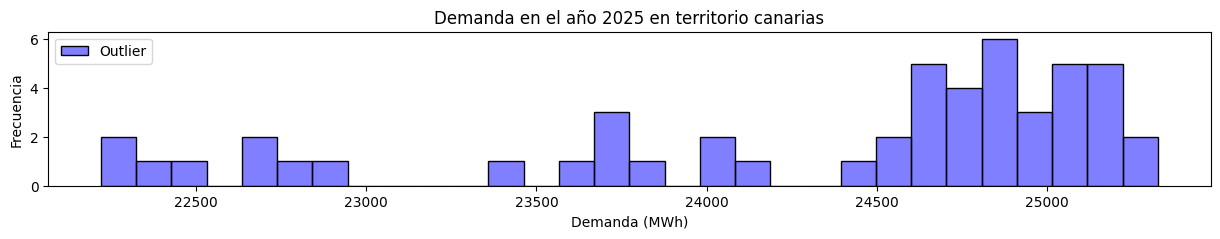

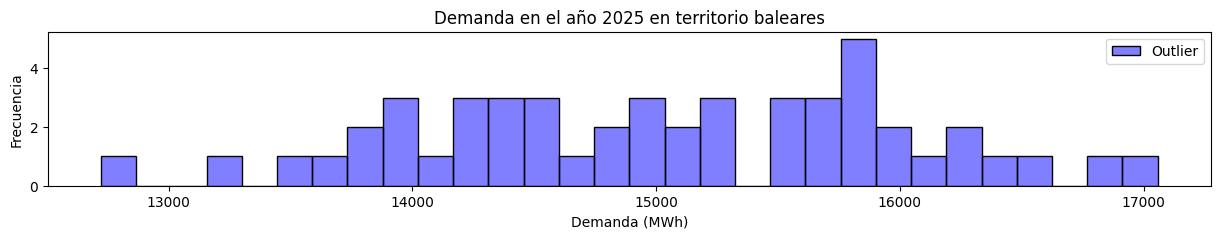

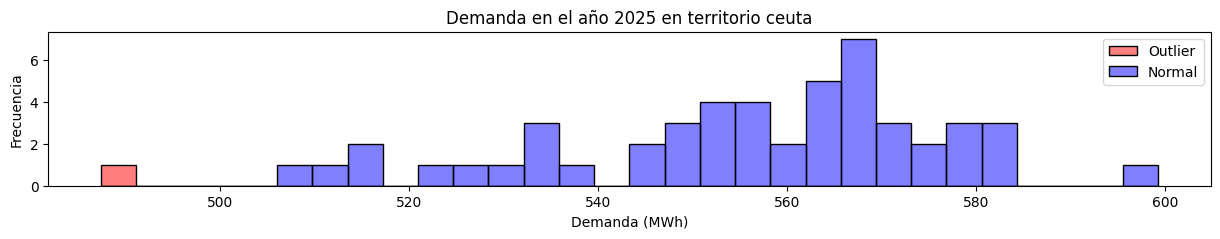

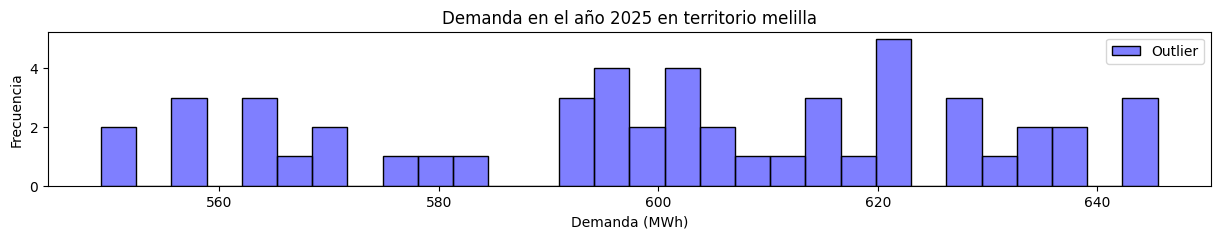

In [26]:
for año in años:
    for territorio in territorios:

        df = df_demanda_historico[(df_demanda_historico["año"] == año) \
                                & (df_demanda_historico["zona"] == territorio)\
                                &(df_demanda_historico["categoria"] == "Evolución de la demanda")]
        try:
            visualiza_outliers_tukey(df, año, territorio)
        except IndexError:
            print(f"No hay datos a visualizar del territorio {territorio} en el año {año}")

#### Aplicamos aisla_outliers_tukey() a todos los años y territorios:

In [27]:
# Aislamos outliers

df_outliers = pd.DataFrame()

for año in años:
    for territorio in territorios:
        try:
            df_outliers = pd.concat([df_outliers, aisla_outliers_tukey(df_demanda_historico, año, territorio)])
        except IndexError:
            print(f"Año {año} en zona {territorio} contiene {len(df_outliers)} registros de outliers")
            continue

Año 2010 en zona nacional contiene 0 registros de outliers
Año 2010 en zona peninsular contiene 0 registros de outliers
Año 2010 en zona canarias contiene 0 registros de outliers
Año 2010 en zona baleares contiene 0 registros de outliers
Año 2010 en zona ceuta contiene 0 registros de outliers
Año 2010 en zona melilla contiene 0 registros de outliers


#### Agrupamos los outliers aislados para ver cuales son los 5 años con más valores atípicos:

In [28]:
años_outliers = df_outliers.groupby(["año"]).count().reset_index().sort_values(by="es_outlier", ascending=False)[["año", "es_outlier"]][:5]
años_outliers

,año,es_outlier
13,2024,81
4,2015,62
8,2019,46
12,2023,43
11,2022,41


In [29]:
demanda_años_outliers = pd.DataFrame()

for idx in range(len(años_outliers["año"].unique())):
    demanda_años_outliers = pd.concat([demanda_años_outliers, df_outliers[(df_outliers["año"] == años_outliers["año"].iloc[idx])]])

demanda_años_outliers = demanda_años_outliers.groupby(["zona", "año", "mes", "dia", "dia_semana"]).agg({"valor_(MWh)":"sum"}).sort_values(by="valor_(MWh)", ascending=False).reset_index()

In [30]:
meses = {
    1: "Enero",
    2 : "Febrero",
    3 : "Marzo",
    4 : "Abril",
    5 : "Mayo",
    6 : "Junio",
    7 : "Julio",
    8 : "Agosto",
    9 : "Septiembre",
    10 : "Octubre",
    11 : "Noviembre",
    12: "Diciembre"
}

demanda_años_outliers["mes"] = demanda_años_outliers["mes"].map(meses)

Podemos usar el dataframe de los outliers para estudiar posibles patrones en los valores atípicos (meses de verano y entre semana suelen ser los días más "problemáticos"):

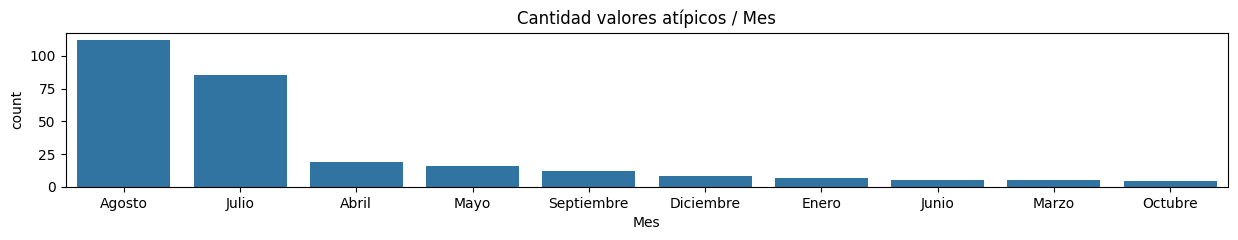

In [31]:
plt.figure(figsize=(15, 2))
sns.countplot(data=demanda_años_outliers, x="mes", order=demanda_años_outliers["mes"].value_counts().index)
plt.title("Cantidad valores atípicos / Mes")
plt.xlabel("Mes")
plt.show()

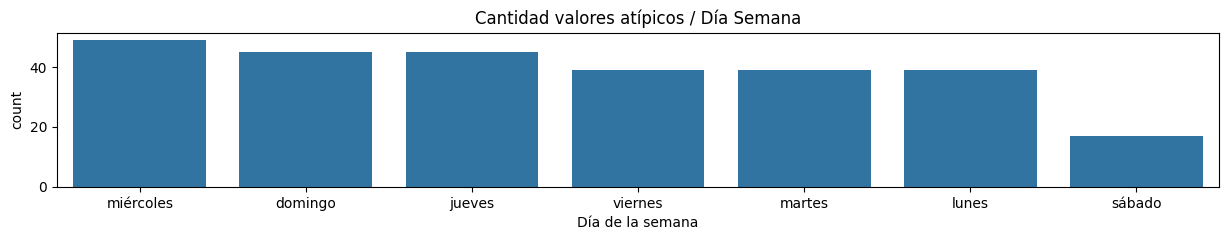

In [32]:
plt.figure(figsize=(15, 2))
sns.countplot(data=demanda_años_outliers, x="dia_semana", order=demanda_años_outliers["dia_semana"].value_counts().index)
plt.title("Cantidad valores atípicos / Día Semana")
plt.xlabel("Día de la semana")
plt.show()

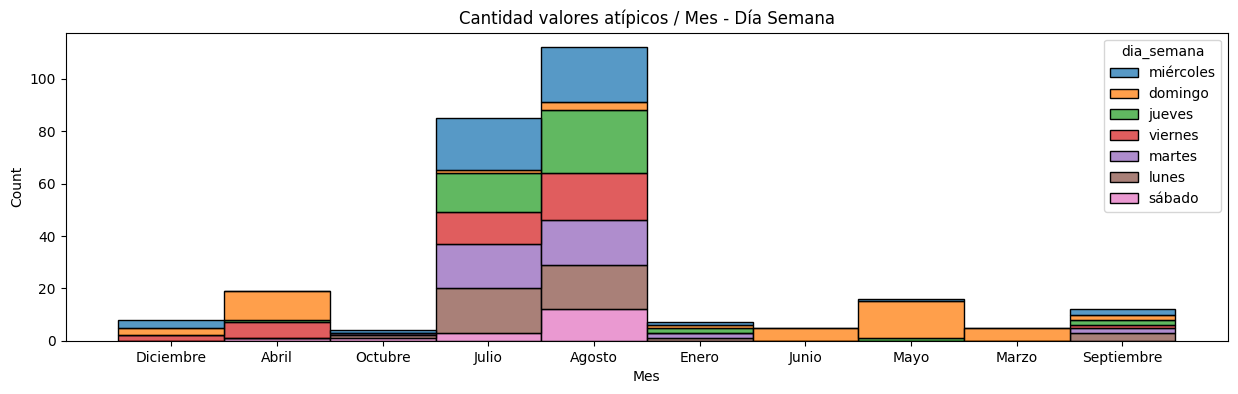

In [33]:
plt.figure(figsize=(15, 4))
sns.histplot(data=demanda_años_outliers, x="mes", hue="dia_semana", multiple="stack", hue_order=demanda_años_outliers["dia_semana"].value_counts().index)
plt.title("Cantidad valores atípicos / Mes - Día Semana")
plt.xlabel("Mes")
plt.show()

#### Aplicamos sustituye_outliers_tukey() a todos los años y territorios para sobreescribir el dataframe de DEMANDA sin datos extremos:

In [34]:
# Al tener los outliers aislados para estudio, sustituimos los valores extremos por limites definidos por límites laterales de Valla de Tukey

for año in años:
    for territorio in territorios:
        try:
            df_demanda_historico.loc[(df_demanda_historico["año"] == año) \
                                    & (df_demanda_historico["zona"] == territorio)\
                                    &(df_demanda_historico["categoria"] == "Evolución de la demanda"), "valor_(MWh)"] \
                                    = sustituye_outliers_tukey(df_demanda_historico.loc[(df_demanda_historico["año"] == año) \
                                    & (df_demanda_historico["zona"] == territorio)\
                                    &(df_demanda_historico["categoria"] == "Evolución de la demanda"), "valor_(MWh)"])
        except IndexError:
            print(f"No hay datos que sobreescribir para año {año} zona {territorio}")

No hay datos que sobreescribir para año 2010 zona nacional
No hay datos que sobreescribir para año 2010 zona peninsular
No hay datos que sobreescribir para año 2010 zona canarias
No hay datos que sobreescribir para año 2010 zona baleares
No hay datos que sobreescribir para año 2010 zona ceuta
No hay datos que sobreescribir para año 2010 zona melilla
